# Training an AI Khipukamayuq

## Data Preprocessing

In order to train an AI Khipukamayuq to parse Inka khipu cord colors, we must first collect cord color data from the Open Khipu Repository ([OKR, v2.0.0](https://zenodo.org/badge/latestdoi/296378423)) that we can use to train the model. Once we have the data, we will also need to preprocess the data to coerce it into a form we can train our model with:

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import subprocess
import pandas as pd
import sqlite3

# download OKR v2.0.0 and select KCCS (Brezine) color codes
# ordered by khipu and cord position
try:
    subprocess.Popen(['git', 
                      'clone', 
                      'https://github.com/khipulab/open-khipu-repository.git',
                      '-b', 'v2.0.0', '--single-branch',
                      '--quiet'])
except Exception as e:
    print(e)

conn = sqlite3.connect('open-khipu-repository/khipu.db')

query = \
'''
SELECT
    okr_num,
    cord.khipu_id,
    cluster_id,
    cord_id,
    cord_ordinal,
    cluster_ordinal,
    /* Get clean colors and concatenate colors of segmented cords */
    (SELECT brezine_color
      FROM
          (SELECT
              GROUP_CONCAT(REPLACE(TRIM(
              c1.color || c1.intensity
                || case when color.operator_1 <> ''
                then '' || color.operator_1 else '' END
                || case when color.color_cd_2 <> ''
                then '' || c2.color || c2.intensity else '' END
                || case when color.operator_2 <> ''
                then '' || color.operator_2 else '' END
                || case when color.color_cd_3 <> ''
                then '' || c3.color || c3.intensity else '' END
                || case when color.operator_3 <> ''
                then '' || color.operator_3 else '' END
                || case when color.color_cd_4 <> ''
                then '' || c4.color || c4.intensity else '' END
                || case when color.operator_4 <> ''
                then '' || color.operator_4 else '' END
                || case when color.color_cd_5 <> ''
                then '' || c5.color || c5.intensity else '' END
                || case when color.operator_5 <> ''
                then '' || color.operator_5 else '' END,
                '*:- '), ' ', ''), '/') AS brezine_color,
            cord_id
          FROM
              ascher_cord_color AS color
          /*
          Find corresponding colors/intensities for Ascher color codes
          using Brezine KCCS lookup table in db.
          Note that some records also have extraneous chars to clean
          */
          LEFT JOIN ascher_color_dc AS c1
              ON REPLACE(TRIM(color.color_cd_1, '*:- '), ' ', '') = \
                REPLACE(TRIM(c1.as_color_cd, '*:- '), ' ', '')
          LEFT JOIN ascher_color_dc AS c2
              ON REPLACE(TRIM(color.color_cd_2, '*:- '), ' ', '') = \
                REPLACE(TRIM(c2.as_color_cd, '*:- '), ' ', '')
          LEFT JOIN ascher_color_dc AS c3
              ON REPLACE(TRIM(color.color_cd_3, '*:- '), ' ', '') = \
                REPLACE(TRIM(c3.as_color_cd, '*:- '), ' ', '')
          LEFT JOIN ascher_color_dc AS c4
              ON REPLACE(TRIM(color.color_cd_4, '*:- '), ' ', '') = \
                REPLACE(TRIM(c4.as_color_cd, '*:- '), ' ', '')
          LEFT JOIN ascher_color_dc AS c5
              ON REPLACE(TRIM(color.color_cd_5, '*:- '), ' ', '') = \
                REPLACE(TRIM(c5.as_color_cd, '*:- '), ' ', '')
          GROUP BY
              cord_id
          ORDER BY
              color_range

          )
      WHERE
          cord_id = cord.cord_id
      ) as color
FROM
    cord
JOIN
    khipu_main ON cord.khipu_id = khipu_main.khipu_id
WHERE
    /*
    First order cords -- top cords indicated with negative in deprecated
    coding scheme, pendant cords with positive
    */
    (cord_level = 1 OR cord_level = -(1))
ORDER BY
    okr_num,
    cord_ordinal
'''

khipu_df = pd.read_sql_query(query, conn)

# label khipus w/o cord groups as their OKR num, so that they have separate cord group numbers
khipus_wo_cg = (khipu_df.CLUSTER_ID == 0) & (khipu_df.CLUSTER_ORDINAL == 0)
khipu_df.loc[khipus_wo_cg,
             'CLUSTER_ID'] = khipu_df.loc[khipus_wo_cg]['OKR_NUM']

# drop (7) cords that are missing cluster ID, but have non-zero cluster ordinal
khipu_df = khipu_df[khipu_df.CLUSTER_ID != 0]
khipu_df.loc[:, 'CLUSTER_ID'] = khipu_df.loc[:, 'CLUSTER_ID'].astype(str)


# Drop khipus that have no recorded colors on them
# (but keep cords without recorded colors if other portions of the khipu
# are recorded)
khipu_ids_to_check = khipu_df.loc[khipu_df.color.isna()] \
                             .groupby('KHIPU_ID') \
                             .count() \
                             .sort_values('color', ascending=False) \
                             .color \
                             .index

all_cord_colors_missing = []
for id in khipu_ids_to_check:
    if len(khipu_df[(khipu_df.KHIPU_ID == id) & (khipu_df.color.isna())]) \
        == (len(khipu_df[(khipu_df.KHIPU_ID == id)])):
        all_cord_colors_missing.append(id)

khipu_df = khipu_df.loc[~khipu_df.KHIPU_ID.isin(all_cord_colors_missing)] \
                   .rename(columns={'OKR_NUM': 'okr_num',
                                    'CLUSTER_ID': 'cluster_id'})
khipu_cg_map = khipu_df[['okr_num', 'cluster_id']].drop_duplicates()

# Drop remaining cords without colors recorded for training tokenizer
cg_df_tok_trn = khipu_df.loc[khipu_df.color.notna(),
                             ['cluster_id', 'color']] \
                        .groupby('cluster_id') \
                        .color.apply(' '.join)

cg_df_tok_trn = pd.merge(left=cg_df_tok_trn,
                         right=khipu_cg_map,
                         on='cluster_id')

# Fill NA values as [UNK] for training model
khipu_df.loc[khipu_df.color.isna(), 'color'] = '[UNK]'
cg_df = khipu_df.loc[:, ['cluster_id', 'color']] \
                .groupby('cluster_id') \
                .color.apply(' '.join)

cg_df = pd.merge(left=cg_df,
                 right=khipu_cg_map,
                 on='cluster_id')

We then have data that looks like so:

In [3]:
cg_df.head()

,cluster_id,color,okr_num
0,1000000,B2 B2 B2,KH0255
1,1000001,B3 B2 B4 B3,KH0255
2,1000002,B3 B4:A1 B3:B4 A1 H2,KH0255
3,1000003,H2,KH0255
4,1000009,A1 A1 A1 A1,KH0244


Note that this dataset includes approximately 50k color recordings:

In [5]:
print("Total number of (first order) cord groups: ", 
      cg_df.cluster_id.count(),
      "\nTotal number of (first order) cords with recorded color: ",
      khipu_df.loc[khipu_df.color != '[UNK]'].color.count(),
      "\nTotal number of (first order) recordings (including color combo cords): ",
      khipu_df.loc[khipu_df.color != '[UNK]'] \
                      .color.str.extractall('([A-Z]{1}[0-9]{1})') \
                      .count()[0]
)

Total number of (first order) cord groups:  6592 
Total number of (first order) cords with recorded color:  37645 
Total number of (first order) recordings (including color combo cords):  48681


## Deep Learning Workflow

The data is now in a form that we can use to train our model. Here, we're primarily interested in interpretive tasks, so we will train a BERT model (an encoder model that will allow us to encode a contextual embedding for each cord in the OKR based on its color and the colors of cords surrounding it in a cord group). Let's first load in some packages and functions that we will use:

In [5]:
from datasets import load_dataset, load_from_disk, Dataset
from transformers import TrainingArguments, Trainer, BertTokenizerFast, BertForMaskedLM, BertConfig, DataCollatorForLanguageModeling
from tokenizers import BertWordPieceTokenizer
import torch
import pandas as pd
import os
import json
from itertools import chain

file_path = "./data"
model_path = "./pretrained-bert"
SEED = 7

# define two functions from documentation for send dataset to file
# and grouping texts together for training
def dataset_to_text(dataset, output_filename="data.txt"):
  '''
  Utility function to save dataset text to disk,
  useful for using the texts to train the tokenizer
  (as the tokenizer accepts files). From HuggingFace documentation.
  '''
  os.makedirs(os.path.dirname(output_filename), exist_ok=True)
  with open(output_filename, "w") as f:
    for t in dataset["color"]:
      print(t, file=f)

def group_texts(examples):
    '''
    Main data processing function that will concatenate all texts from our
    dataset and generate chunks of max_seq_length. From example code:
    https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py

    Note that, when mapping this function using `map` with `batched=True`,
    map processes 1,000 texts together, so group_texts throws away a remainder
    for each of those groups of 1,000 texts (can adjust batch_size as needed).
    '''
    # Concatenate all texts.
    concatenated_examples = {k: list(chain(*examples[k])) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
    # customize this part to your needs.
    if total_length >= max_length:
        total_length = (total_length // max_length) * max_length
    # Split by chunks of max_length
    result = {
        k: [t[i : i + max_length] for i in range(0, total_length, max_length)]
        for k, t in concatenated_examples.items()
    }
    return result

### Read Data for Training Tokenizer and BERT

Then, let's load in our `pandas` DataFrames as `Dataset` objects. We can also split up our data into training and testing data.

In [6]:
# Process dataset and write to file for training tokenizer
dataset_tok_trn = Dataset.from_pandas(cg_df_tok_trn[['color']] \
                         .reset_index(drop=True))
dataset_to_text(dataset_tok_trn, f"{file_path}/tok_trn.txt")

# Read in full dataset for training BERT and split into train/test data
dataset = Dataset.from_pandas(cg_df.reset_index(drop=True))

d = dataset.train_test_split(test_size=0.2, seed=SEED)

In [7]:
d['train'][:5] # see what the data looks like

{'cluster_id': ['1005554', '1003449', '1019734', '1013530', '1019117'],
 'color': ['B3 B2:B3:A1 B3:A1 B3:A1',
  'A1*Z5/A1/A1*Z5/A1',
  'A1 B3 B4:B2 B4:A1 B2 H3 B2',
  'B3 B3 B3 B3',
  '[UNK]'],
 'okr_num': ['KH0014', 'KH0082', 'KH0081', 'KH0079', 'KH0502']}

### Train Tokenizer

We then need to train a tokenizer to learn distinct cord colors as well as standard cord color combination operators and special tokens that can be recognized by the BERT model -- i.e. separations between cord groups, the start of cord group sequences, masked cords, etc. Note that a small subset of color combination cords (19) are recorded without color combination operators in the OKR. In the absence of additional information about how they were formed, these colors are denoted with their own unique (multi-color) tokens in the tokenizer's vocabulary.

We can train our tokenizer like so:

In [8]:
# BERT special tokens
special_tokens = [
  "[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]", "<S>", "<T>"
]

# maximum sequence length
max_length = 512

# initialize the tokenizer
tokenizer = BertWordPieceTokenizer()

# train the tokenizer
tokenizer.train(files=[f"{file_path}/tok_trn.txt"],
                special_tokens=special_tokens)

# make a directory if not already there
if not os.path.isdir(model_path):
  os.mkdir(model_path)

# save the tokenizer
tokenizer.save_model(model_path)

# save tokenizer config to file
with open(os.path.join(model_path, "config.json"), "w") as f:
  tokenizer_cfg = {
      "do_lower_case": True,
      "unk_token": "[UNK]",
      "sep_token": "[SEP]",
      "pad_token": "[PAD]",
      "cls_token": "[CLS]",
      "mask_token": "[MASK]",
      "model_max_length": max_length,
      "max_len": max_length,
  }
  json.dump(tokenizer_cfg, f)

### Tokenize Train/Test Data

Now we can load our tokenizer and use it to tokenize our test and training data.

In [ ]:
# when the tokenizer is trained and configured, load it as BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained(model_path)

# Mapping function to tokenize with truncation + padding to match max length
encode = lambda x: tokenizer(x["color"],
                             return_special_tokens_mask=True,
                             truncation=True,
                             max_length=max_length)

# tokenize train and test data
train_dataset = d["train"].map(encode, batched=True)

# tokenizing the testing dataset
test_dataset = d["test"].map(encode, batched=True)

# Concatenate color groupings together to max length accepted by model per line
train_dataset = train_dataset.map(group_texts, batched=True,
                              desc=f"Grouping texts in chunks of {max_length}")
test_dataset = test_dataset.map(group_texts, batched=True,
                              desc=f"Grouping texts in chunks of {max_length}")

# convert from lists to torch tensors
train_dataset.set_format(type="torch", columns=["input_ids",
                                                "attention_mask",
                                                "special_tokens_mask"])
test_dataset.set_format(type="torch", columns=["input_ids",
                                               "attention_mask",
                                               "special_tokens_mask"])

# save tokenized training and test data for training BERT model
train_dataset.save_to_disk(f"{file_path}/train")
test_dataset.save_to_disk(f"{file_path}/test")

## Training the Model

Finally, we can train our BERT model using the tokenized train and test data we just produced (note that I ran the script `./hp_search.py` to perform a hyperparameter search for the optimal learning rate -- incorporated below). The code in `hp_search.py` and below is best run on a GPU (this code was tested on a NVIDIA T4 GPU in the Google Cloud, as well as on a NVIDIA RTX 4060 laptop GPU). The pretrained model has been saved to this repository and can also be loaded for use in `analysis.ipynb` without running this code.

In [2]:
# load data
train_dataset = load_from_disk(f"{file_path}/train")
test_dataset = load_from_disk(f"{file_path}/test")

# load tokenizer
tokenizer = BertTokenizerFast.from_pretrained(model_path)

model_config = BertConfig(max_position_embeddings=512)
model = BertForMaskedLM(config=model_config)

# initialize the data collator, randomly masking 15% of the tokens for
# the Masked Language Modeling (MLM) prediction task
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15
)

# Learning rate selected by running ./hp_search.py
# Save model after 400 steps
training_args = TrainingArguments(
    output_dir=model_path,
    evaluation_strategy="steps",
    overwrite_output_dir=True,
    max_steps=400,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,
    learning_rate=5e-5,
    logging_steps=10,
    save_steps=100,       
    save_total_limit=1,
    seed=SEED
)

# initialize the trainer and pass everything to it
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# train the model
trainer.train()

max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: cluster_id, color, special_tokens_mask, okr_num. If cluster_id, color, special_tokens_mask, okr_num are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
c:\Users\jclindaniel\AppData\Local\anaconda3\envs\bearc\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 68
  Num Epochs = 24
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 4
  Total optimization steps = 400


  0%|          | 0/400 [00:00<?, ?it/s]

The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: cluster_id, color, special_tokens_mask, okr_num. If cluster_id, color, special_tokens_mask, okr_num are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17
  Batch size = 1


{'loss': 6.3689, 'learning_rate': 4.875e-05, 'epoch': 0.59}


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 4.754756927490234, 'eval_runtime': 0.5475, 'eval_samples_per_second': 31.05, 'eval_steps_per_second': 31.05, 'epoch': 0.59}


The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: cluster_id, color, special_tokens_mask, okr_num. If cluster_id, color, special_tokens_mask, okr_num are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17
  Batch size = 1


{'loss': 4.5204, 'learning_rate': 4.75e-05, 'epoch': 1.18}


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 4.154697418212891, 'eval_runtime': 0.5379, 'eval_samples_per_second': 31.604, 'eval_steps_per_second': 31.604, 'epoch': 1.18}


The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: cluster_id, color, special_tokens_mask, okr_num. If cluster_id, color, special_tokens_mask, okr_num are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17
  Batch size = 1


{'loss': 3.9122, 'learning_rate': 4.6250000000000006e-05, 'epoch': 1.76}


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 3.517988681793213, 'eval_runtime': 0.5395, 'eval_samples_per_second': 31.513, 'eval_steps_per_second': 31.513, 'epoch': 1.76}


The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: cluster_id, color, special_tokens_mask, okr_num. If cluster_id, color, special_tokens_mask, okr_num are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17
  Batch size = 1


{'loss': 3.4944, 'learning_rate': 4.5e-05, 'epoch': 2.35}


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 3.135415554046631, 'eval_runtime': 0.5664, 'eval_samples_per_second': 30.013, 'eval_steps_per_second': 30.013, 'epoch': 2.35}


The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: cluster_id, color, special_tokens_mask, okr_num. If cluster_id, color, special_tokens_mask, okr_num are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17
  Batch size = 1


{'loss': 3.1173, 'learning_rate': 4.375e-05, 'epoch': 2.94}


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 3.0580060482025146, 'eval_runtime': 0.5433, 'eval_samples_per_second': 31.288, 'eval_steps_per_second': 31.288, 'epoch': 2.94}


The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: cluster_id, color, special_tokens_mask, okr_num. If cluster_id, color, special_tokens_mask, okr_num are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17
  Batch size = 1


{'loss': 3.075, 'learning_rate': 4.25e-05, 'epoch': 3.53}


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 2.769441604614258, 'eval_runtime': 0.5513, 'eval_samples_per_second': 30.837, 'eval_steps_per_second': 30.837, 'epoch': 3.53}


The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: cluster_id, color, special_tokens_mask, okr_num. If cluster_id, color, special_tokens_mask, okr_num are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17
  Batch size = 1


{'loss': 2.698, 'learning_rate': 4.125e-05, 'epoch': 4.12}


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 2.4883182048797607, 'eval_runtime': 0.6298, 'eval_samples_per_second': 26.993, 'eval_steps_per_second': 26.993, 'epoch': 4.12}


The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: cluster_id, color, special_tokens_mask, okr_num. If cluster_id, color, special_tokens_mask, okr_num are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17
  Batch size = 1


{'loss': 2.5274, 'learning_rate': 4e-05, 'epoch': 4.71}


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 2.4609286785125732, 'eval_runtime': 0.676, 'eval_samples_per_second': 25.148, 'eval_steps_per_second': 25.148, 'epoch': 4.71}


The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: cluster_id, color, special_tokens_mask, okr_num. If cluster_id, color, special_tokens_mask, okr_num are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17
  Batch size = 1


{'loss': 2.3652, 'learning_rate': 3.875e-05, 'epoch': 5.29}


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 2.1892290115356445, 'eval_runtime': 1.2918, 'eval_samples_per_second': 13.16, 'eval_steps_per_second': 13.16, 'epoch': 5.29}


The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: cluster_id, color, special_tokens_mask, okr_num. If cluster_id, color, special_tokens_mask, okr_num are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17
  Batch size = 1


{'loss': 2.3224, 'learning_rate': 3.7500000000000003e-05, 'epoch': 5.88}


  0%|          | 0/17 [00:00<?, ?it/s]

Saving model checkpoint to ./pretrained-bert\checkpoint-100
Configuration saved in ./pretrained-bert\checkpoint-100\config.json


{'eval_loss': 2.2673215866088867, 'eval_runtime': 0.7937, 'eval_samples_per_second': 21.418, 'eval_steps_per_second': 21.418, 'epoch': 5.88}


Model weights saved in ./pretrained-bert\checkpoint-100\pytorch_model.bin
Deleting older checkpoint [pretrained-bert\checkpoint-400-use] due to args.save_total_limit
The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: cluster_id, color, special_tokens_mask, okr_num. If cluster_id, color, special_tokens_mask, okr_num are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17
  Batch size = 1


{'loss': 2.2901, 'learning_rate': 3.625e-05, 'epoch': 6.47}


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 2.1622025966644287, 'eval_runtime': 0.8513, 'eval_samples_per_second': 19.968, 'eval_steps_per_second': 19.968, 'epoch': 6.47}


The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: cluster_id, color, special_tokens_mask, okr_num. If cluster_id, color, special_tokens_mask, okr_num are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17
  Batch size = 1


{'loss': 2.161, 'learning_rate': 3.5e-05, 'epoch': 7.06}


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 2.13019061088562, 'eval_runtime': 0.7943, 'eval_samples_per_second': 21.403, 'eval_steps_per_second': 21.403, 'epoch': 7.06}


The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: cluster_id, color, special_tokens_mask, okr_num. If cluster_id, color, special_tokens_mask, okr_num are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17
  Batch size = 1


{'loss': 2.1634, 'learning_rate': 3.375000000000001e-05, 'epoch': 7.65}


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 2.0932505130767822, 'eval_runtime': 2.1319, 'eval_samples_per_second': 7.974, 'eval_steps_per_second': 7.974, 'epoch': 7.65}


The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: cluster_id, color, special_tokens_mask, okr_num. If cluster_id, color, special_tokens_mask, okr_num are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17
  Batch size = 1


{'loss': 2.0706, 'learning_rate': 3.2500000000000004e-05, 'epoch': 8.24}


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 2.043602466583252, 'eval_runtime': 1.89, 'eval_samples_per_second': 8.995, 'eval_steps_per_second': 8.995, 'epoch': 8.24}


The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: cluster_id, color, special_tokens_mask, okr_num. If cluster_id, color, special_tokens_mask, okr_num are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17
  Batch size = 1


{'loss': 2.1683, 'learning_rate': 3.125e-05, 'epoch': 8.82}


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 2.057720422744751, 'eval_runtime': 2.2585, 'eval_samples_per_second': 7.527, 'eval_steps_per_second': 7.527, 'epoch': 8.82}


The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: cluster_id, color, special_tokens_mask, okr_num. If cluster_id, color, special_tokens_mask, okr_num are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17
  Batch size = 1


{'loss': 2.0331, 'learning_rate': 3e-05, 'epoch': 9.41}


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 2.0538573265075684, 'eval_runtime': 2.3233, 'eval_samples_per_second': 7.317, 'eval_steps_per_second': 7.317, 'epoch': 9.41}


The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: cluster_id, color, special_tokens_mask, okr_num. If cluster_id, color, special_tokens_mask, okr_num are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17
  Batch size = 1


{'loss': 2.0104, 'learning_rate': 2.8749999999999997e-05, 'epoch': 10.0}


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 2.0223894119262695, 'eval_runtime': 1.2372, 'eval_samples_per_second': 13.741, 'eval_steps_per_second': 13.741, 'epoch': 10.0}


The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: cluster_id, color, special_tokens_mask, okr_num. If cluster_id, color, special_tokens_mask, okr_num are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17
  Batch size = 1


{'loss': 2.0394, 'learning_rate': 2.7500000000000004e-05, 'epoch': 10.59}


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 2.0721893310546875, 'eval_runtime': 1.0368, 'eval_samples_per_second': 16.397, 'eval_steps_per_second': 16.397, 'epoch': 10.59}


The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: cluster_id, color, special_tokens_mask, okr_num. If cluster_id, color, special_tokens_mask, okr_num are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17
  Batch size = 1


{'loss': 2.0728, 'learning_rate': 2.625e-05, 'epoch': 11.18}


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 2.020432949066162, 'eval_runtime': 1.6198, 'eval_samples_per_second': 10.495, 'eval_steps_per_second': 10.495, 'epoch': 11.18}


The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: cluster_id, color, special_tokens_mask, okr_num. If cluster_id, color, special_tokens_mask, okr_num are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17
  Batch size = 1


{'loss': 2.0742, 'learning_rate': 2.5e-05, 'epoch': 11.76}


  0%|          | 0/17 [00:00<?, ?it/s]

Saving model checkpoint to ./pretrained-bert\checkpoint-200
Configuration saved in ./pretrained-bert\checkpoint-200\config.json


{'eval_loss': 2.032832384109497, 'eval_runtime': 1.7962, 'eval_samples_per_second': 9.464, 'eval_steps_per_second': 9.464, 'epoch': 11.76}


Model weights saved in ./pretrained-bert\checkpoint-200\pytorch_model.bin
Deleting older checkpoint [pretrained-bert\checkpoint-100] due to args.save_total_limit
The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: cluster_id, color, special_tokens_mask, okr_num. If cluster_id, color, special_tokens_mask, okr_num are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17
  Batch size = 1


{'loss': 2.0086, 'learning_rate': 2.375e-05, 'epoch': 12.35}


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 1.9972538948059082, 'eval_runtime': 3.1788, 'eval_samples_per_second': 5.348, 'eval_steps_per_second': 5.348, 'epoch': 12.35}


The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: cluster_id, color, special_tokens_mask, okr_num. If cluster_id, color, special_tokens_mask, okr_num are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17
  Batch size = 1


{'loss': 1.9813, 'learning_rate': 2.25e-05, 'epoch': 12.94}


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 2.0342488288879395, 'eval_runtime': 0.796, 'eval_samples_per_second': 21.356, 'eval_steps_per_second': 21.356, 'epoch': 12.94}


The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: cluster_id, color, special_tokens_mask, okr_num. If cluster_id, color, special_tokens_mask, okr_num are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17
  Batch size = 1


{'loss': 1.9828, 'learning_rate': 2.125e-05, 'epoch': 13.53}


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 2.0955018997192383, 'eval_runtime': 1.2666, 'eval_samples_per_second': 13.422, 'eval_steps_per_second': 13.422, 'epoch': 13.53}


The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: cluster_id, color, special_tokens_mask, okr_num. If cluster_id, color, special_tokens_mask, okr_num are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17
  Batch size = 1


{'loss': 1.9814, 'learning_rate': 2e-05, 'epoch': 14.12}


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 1.9588403701782227, 'eval_runtime': 0.6975, 'eval_samples_per_second': 24.374, 'eval_steps_per_second': 24.374, 'epoch': 14.12}


The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: cluster_id, color, special_tokens_mask, okr_num. If cluster_id, color, special_tokens_mask, okr_num are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17
  Batch size = 1


{'loss': 1.951, 'learning_rate': 1.8750000000000002e-05, 'epoch': 14.71}


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 2.066065788269043, 'eval_runtime': 0.6032, 'eval_samples_per_second': 28.183, 'eval_steps_per_second': 28.183, 'epoch': 14.71}


The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: cluster_id, color, special_tokens_mask, okr_num. If cluster_id, color, special_tokens_mask, okr_num are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17
  Batch size = 1


{'loss': 2.0126, 'learning_rate': 1.75e-05, 'epoch': 15.29}


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 1.948521375656128, 'eval_runtime': 0.5946, 'eval_samples_per_second': 28.591, 'eval_steps_per_second': 28.591, 'epoch': 15.29}


The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: cluster_id, color, special_tokens_mask, okr_num. If cluster_id, color, special_tokens_mask, okr_num are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17
  Batch size = 1


{'loss': 1.9675, 'learning_rate': 1.6250000000000002e-05, 'epoch': 15.88}


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 1.9857310056686401, 'eval_runtime': 0.6068, 'eval_samples_per_second': 28.017, 'eval_steps_per_second': 28.017, 'epoch': 15.88}


The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: cluster_id, color, special_tokens_mask, okr_num. If cluster_id, color, special_tokens_mask, okr_num are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17
  Batch size = 1


{'loss': 1.9996, 'learning_rate': 1.5e-05, 'epoch': 16.47}


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 1.942827820777893, 'eval_runtime': 0.9039, 'eval_samples_per_second': 18.807, 'eval_steps_per_second': 18.807, 'epoch': 16.47}


The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: cluster_id, color, special_tokens_mask, okr_num. If cluster_id, color, special_tokens_mask, okr_num are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17
  Batch size = 1


{'loss': 1.9634, 'learning_rate': 1.3750000000000002e-05, 'epoch': 17.06}


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 1.9941967725753784, 'eval_runtime': 0.9006, 'eval_samples_per_second': 18.876, 'eval_steps_per_second': 18.876, 'epoch': 17.06}


The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: cluster_id, color, special_tokens_mask, okr_num. If cluster_id, color, special_tokens_mask, okr_num are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17
  Batch size = 1


{'loss': 1.9657, 'learning_rate': 1.25e-05, 'epoch': 17.65}


  0%|          | 0/17 [00:00<?, ?it/s]

Saving model checkpoint to ./pretrained-bert\checkpoint-300
Configuration saved in ./pretrained-bert\checkpoint-300\config.json


{'eval_loss': 1.9472496509552002, 'eval_runtime': 0.843, 'eval_samples_per_second': 20.167, 'eval_steps_per_second': 20.167, 'epoch': 17.65}


Model weights saved in ./pretrained-bert\checkpoint-300\pytorch_model.bin
Deleting older checkpoint [pretrained-bert\checkpoint-200] due to args.save_total_limit
The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: cluster_id, color, special_tokens_mask, okr_num. If cluster_id, color, special_tokens_mask, okr_num are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17
  Batch size = 1


{'loss': 1.9365, 'learning_rate': 1.125e-05, 'epoch': 18.24}


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 1.9396028518676758, 'eval_runtime': 0.7251, 'eval_samples_per_second': 23.446, 'eval_steps_per_second': 23.446, 'epoch': 18.24}


The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: cluster_id, color, special_tokens_mask, okr_num. If cluster_id, color, special_tokens_mask, okr_num are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17
  Batch size = 1


{'loss': 1.9487, 'learning_rate': 1e-05, 'epoch': 18.82}


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 1.9598592519760132, 'eval_runtime': 0.6008, 'eval_samples_per_second': 28.298, 'eval_steps_per_second': 28.298, 'epoch': 18.82}


The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: cluster_id, color, special_tokens_mask, okr_num. If cluster_id, color, special_tokens_mask, okr_num are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17
  Batch size = 1


{'loss': 1.9245, 'learning_rate': 8.75e-06, 'epoch': 19.41}


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 2.03629994392395, 'eval_runtime': 0.5787, 'eval_samples_per_second': 29.376, 'eval_steps_per_second': 29.376, 'epoch': 19.41}


The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: cluster_id, color, special_tokens_mask, okr_num. If cluster_id, color, special_tokens_mask, okr_num are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17
  Batch size = 1


{'loss': 1.9294, 'learning_rate': 7.5e-06, 'epoch': 20.0}


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 1.9858273267745972, 'eval_runtime': 0.5901, 'eval_samples_per_second': 28.811, 'eval_steps_per_second': 28.811, 'epoch': 20.0}


The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: cluster_id, color, special_tokens_mask, okr_num. If cluster_id, color, special_tokens_mask, okr_num are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17
  Batch size = 1


{'loss': 1.9591, 'learning_rate': 6.25e-06, 'epoch': 20.59}


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 1.99700927734375, 'eval_runtime': 0.6345, 'eval_samples_per_second': 26.791, 'eval_steps_per_second': 26.791, 'epoch': 20.59}


The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: cluster_id, color, special_tokens_mask, okr_num. If cluster_id, color, special_tokens_mask, okr_num are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17
  Batch size = 1


{'loss': 1.8875, 'learning_rate': 5e-06, 'epoch': 21.18}


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 2.0407402515411377, 'eval_runtime': 0.5975, 'eval_samples_per_second': 28.451, 'eval_steps_per_second': 28.451, 'epoch': 21.18}


The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: cluster_id, color, special_tokens_mask, okr_num. If cluster_id, color, special_tokens_mask, okr_num are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17
  Batch size = 1


{'loss': 1.951, 'learning_rate': 3.75e-06, 'epoch': 21.76}


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 1.9535870552062988, 'eval_runtime': 0.5573, 'eval_samples_per_second': 30.505, 'eval_steps_per_second': 30.505, 'epoch': 21.76}


The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: cluster_id, color, special_tokens_mask, okr_num. If cluster_id, color, special_tokens_mask, okr_num are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17
  Batch size = 1


{'loss': 1.9231, 'learning_rate': 2.5e-06, 'epoch': 22.35}


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 1.9978704452514648, 'eval_runtime': 0.5954, 'eval_samples_per_second': 28.55, 'eval_steps_per_second': 28.55, 'epoch': 22.35}


The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: cluster_id, color, special_tokens_mask, okr_num. If cluster_id, color, special_tokens_mask, okr_num are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17
  Batch size = 1


{'loss': 2.0096, 'learning_rate': 1.25e-06, 'epoch': 22.94}


  0%|          | 0/17 [00:00<?, ?it/s]

{'eval_loss': 1.9650108814239502, 'eval_runtime': 0.6476, 'eval_samples_per_second': 26.252, 'eval_steps_per_second': 26.252, 'epoch': 22.94}


The following columns in the evaluation set  don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: cluster_id, color, special_tokens_mask, okr_num. If cluster_id, color, special_tokens_mask, okr_num are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17
  Batch size = 1


{'loss': 1.9332, 'learning_rate': 0.0, 'epoch': 23.53}


  0%|          | 0/17 [00:00<?, ?it/s]

Saving model checkpoint to ./pretrained-bert\checkpoint-400
Configuration saved in ./pretrained-bert\checkpoint-400\config.json


{'eval_loss': 1.8822731971740723, 'eval_runtime': 0.7716, 'eval_samples_per_second': 22.033, 'eval_steps_per_second': 22.033, 'epoch': 23.53}


Model weights saved in ./pretrained-bert\checkpoint-400\pytorch_model.bin
Deleting older checkpoint [pretrained-bert\checkpoint-300] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)




{'train_runtime': 300.1643, 'train_samples_per_second': 5.33, 'train_steps_per_second': 1.333, 'train_loss': 2.3675238847732545, 'epoch': 23.53}


TrainOutput(global_step=400, training_loss=2.3675238847732545, metrics={'train_runtime': 300.1643, 'train_samples_per_second': 5.33, 'train_steps_per_second': 1.333, 'train_loss': 2.3675238847732545, 'epoch': 23.53})

It seems like our model is fairly robust -- it has converged to a stable (low) error rate and performs similarly well with held-out validation data that it has never seen before.

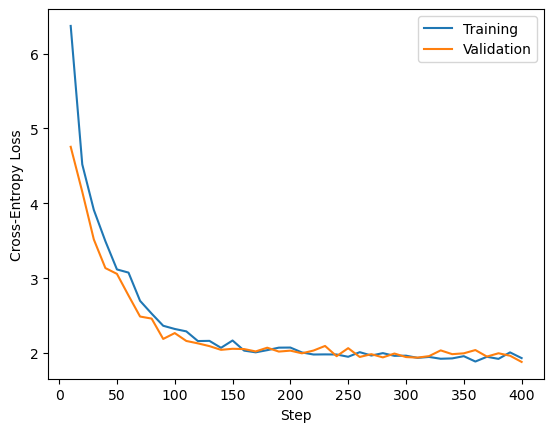

In [3]:
# Collect training and Evaluation Loss
log = pd.DataFrame(trainer.state.log_history)
train_loss = log[['loss', 'step']].dropna().rename(columns={'loss': 'training_loss'})
eval_loss = log[['eval_loss', 'step']].dropna().rename(columns={'eval_loss': 'validation_loss'})

# Plot them
ax = train_loss.plot(x='step')
eval_loss.plot(x='step', ax=ax)
ax.set_xlabel('Step')
ax.set_ylabel('Cross-Entropy Loss')
ax.legend(labels=['Training', 'Validation']);

The model was saved at the last checkpoint (400 steps), so we can load and use it in `khipubert_analysis.ipynb` to interpret what it has learned about how cord colors were used in Inka khipus.